In [1]:
from ctraptools.kymos.detect import Detector
from lumicks import pylake

import ctraptools.kymos.stepfinding as ksf
import ctraptools.kymos.io as kio
import os

In [2]:
# Parameters
path = "/Users/sc13967/Documents/People/Alex Hughes-Games/2023-12-11 Binding rebinding/EcoP15I sliding diffusion/20230512-150855 Kymograph 4 into 4 mM ATP sliding.h5"
channel = 0

In [3]:
# Loading kymograph as image
if os.path.splitext(path)[1] == ".tif":
    image = kio.read_image(path,channel,x_range=None)
elif os.path.splitext(path)[1] == ".h5" or os.path.splitext(path)[1] == ".hdf5":
    file = pylake.File(path)
    kymo = next(iter(file.kymos.values()))
    image = kymo.get_image()[:,:,channel]

rootpath = os.path.dirname(path)+'/'
rootname = os.path.basename(os.path.splitext(path)[0])

In [4]:
# Cropping the image in the x-axis
# image = image[:,0:500]

In [5]:
# Initialising Detector
half_t_w = 0
detector = Detector(half_t_w=half_t_w,peak_det_thresh = 5, n_max=10, c_ub=5, c_def=3, min_track_length = 10, track_heritage_weight=100)

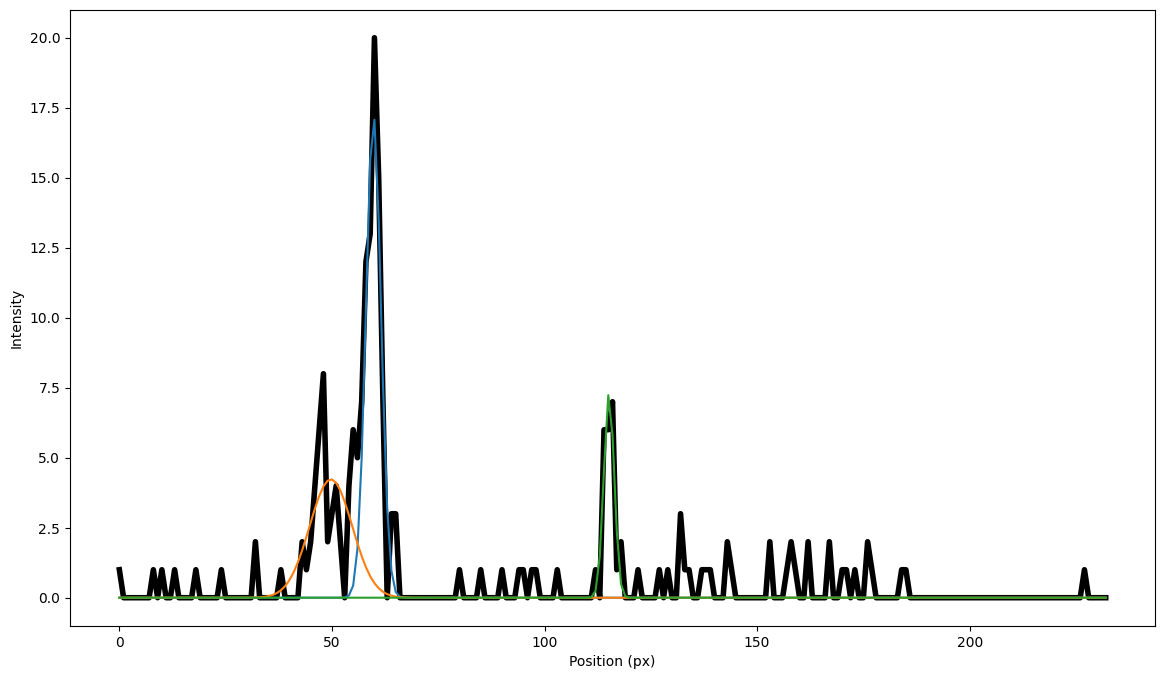

In [6]:
# (Optional) Testing fit parameters
fr = 396
peaks = detector.fit_peaks(image,fr)
kio.plot_gauss_for_frame(peaks,fr,image,half_t_w=half_t_w)

In [7]:
# Detect peaks and track
tracks = detector.detect(image)

100%|██████████| 500/500 [00:44<00:00, 11.14it/s] 


/Users/sc13967/Documents/Programming/Python/ctraptools/.venv/lib/python3.9/site-packages/ctraptools/kymos/io.py:158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,6))


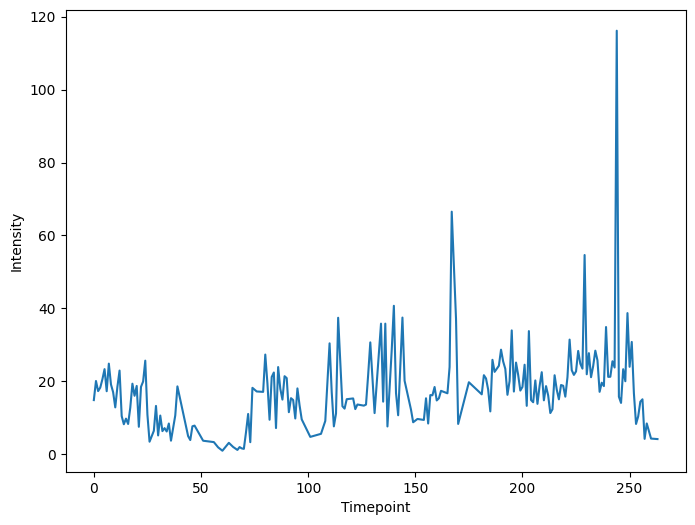

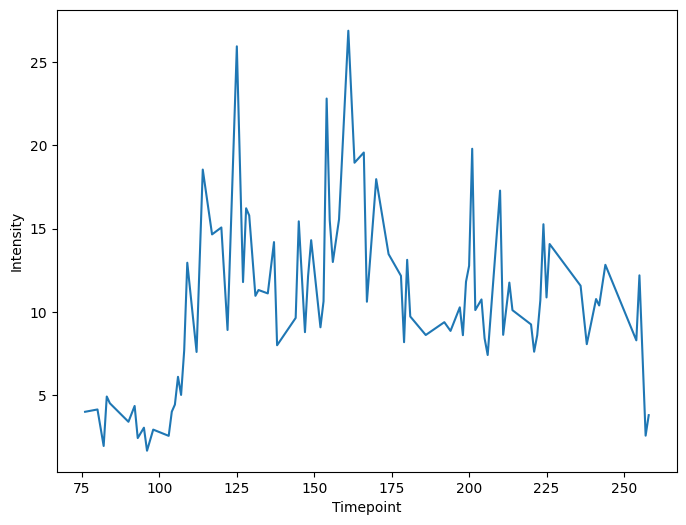

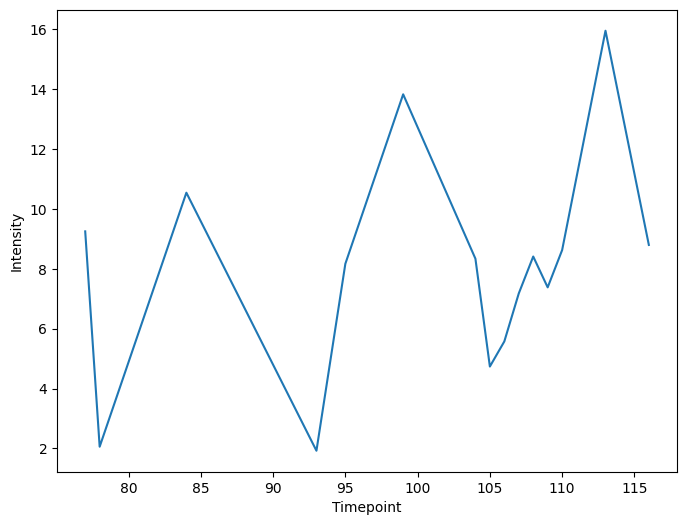

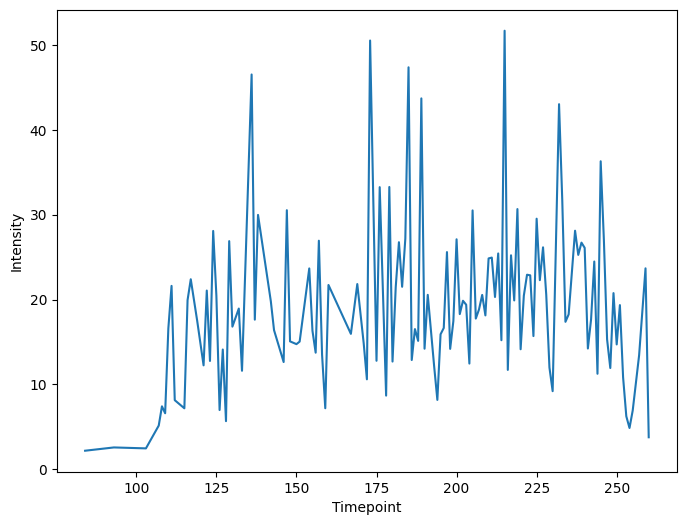

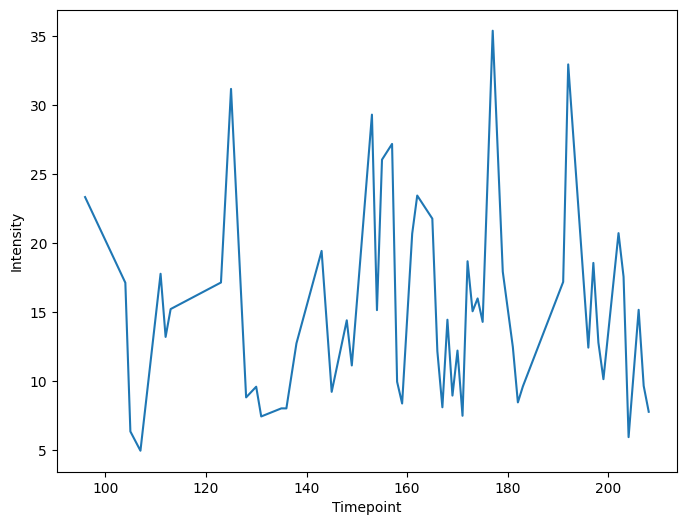

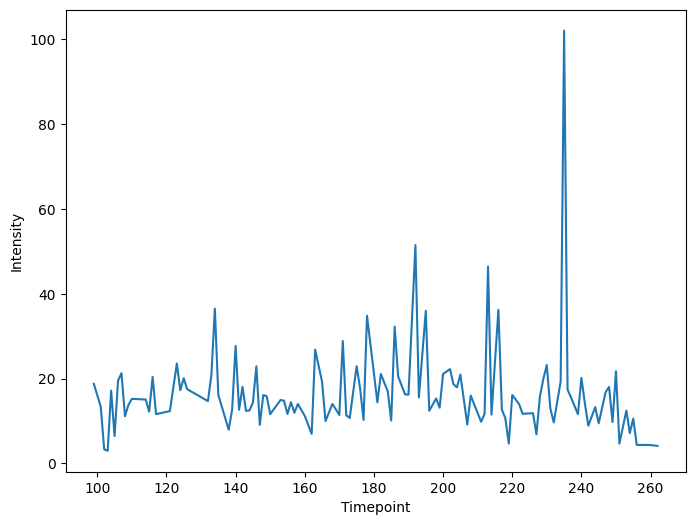

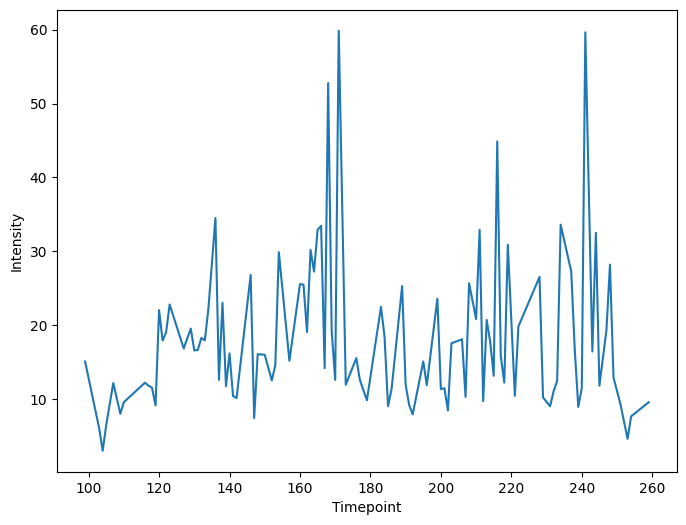

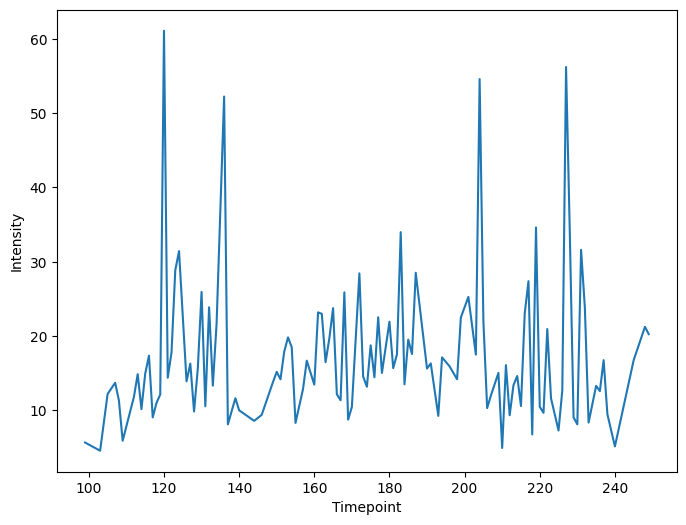

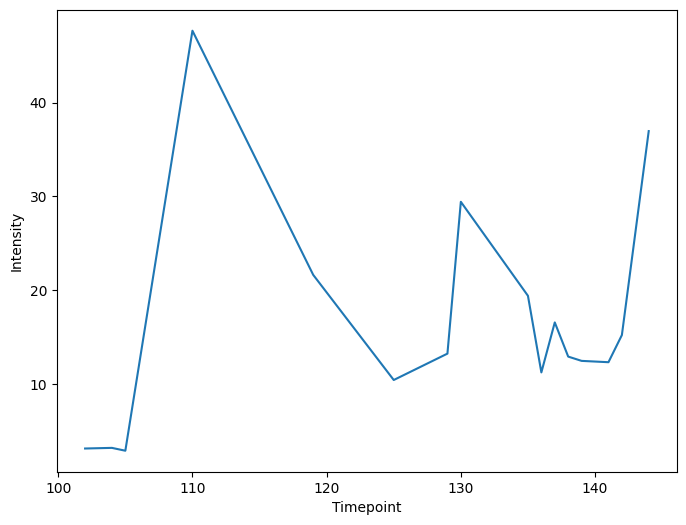

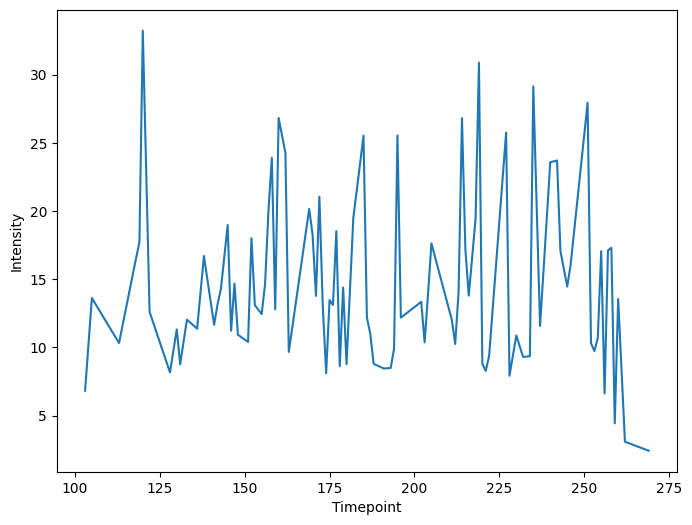

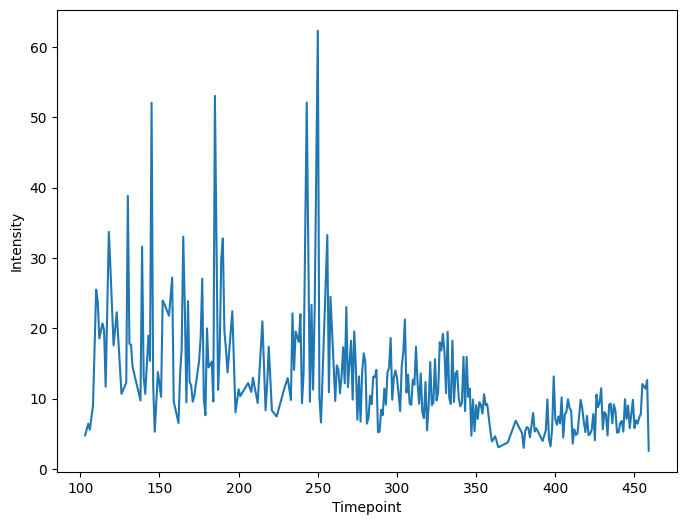

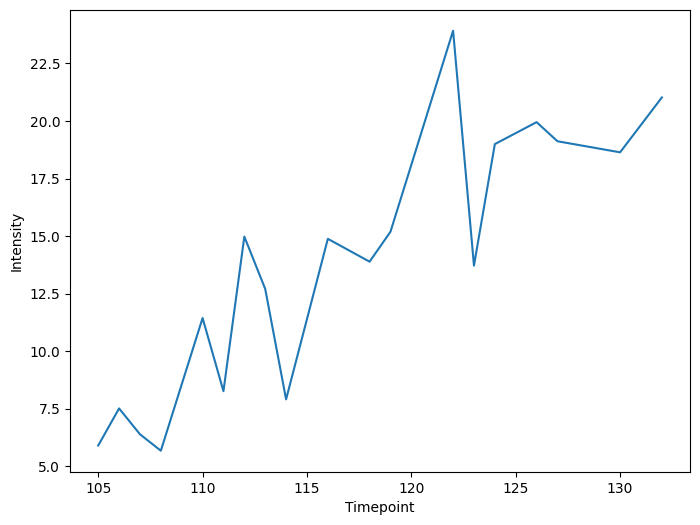

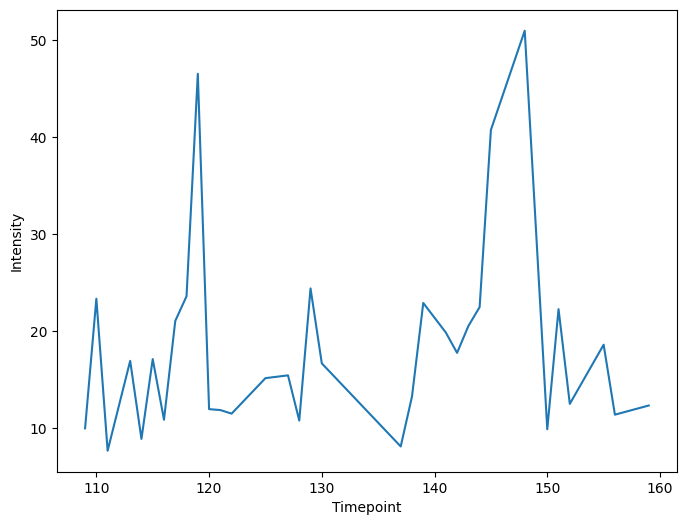

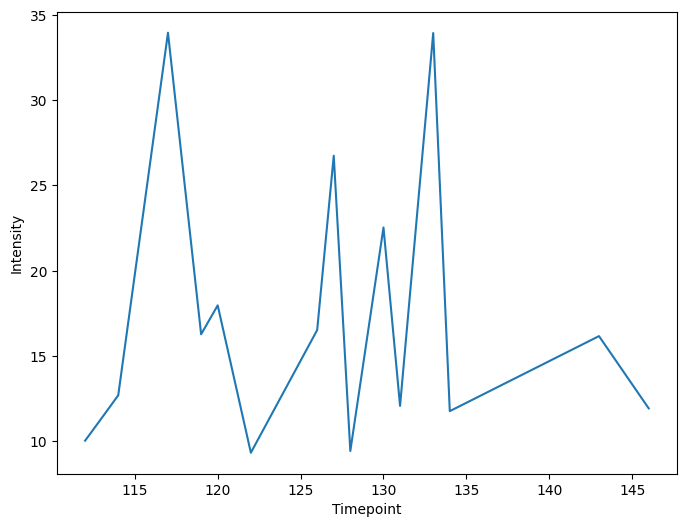

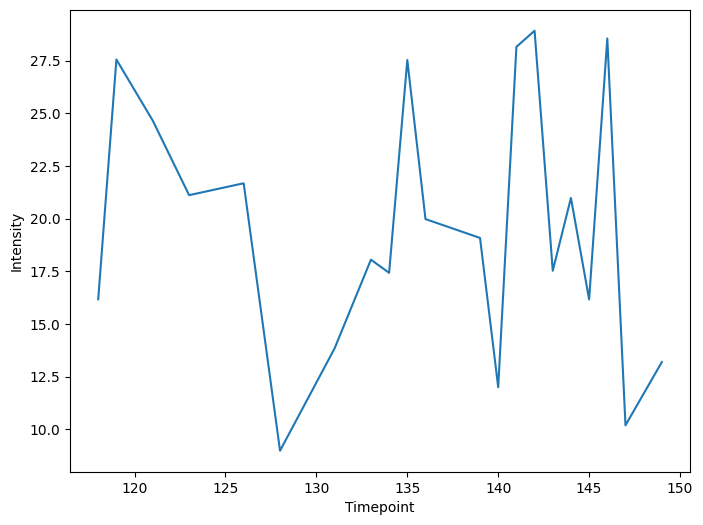

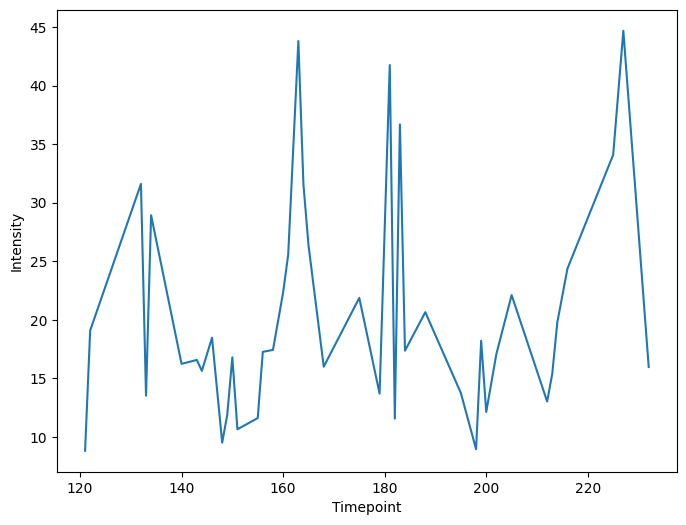

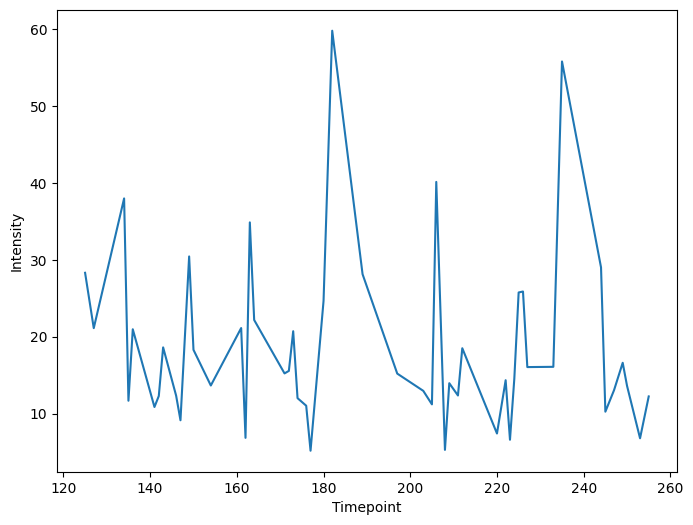

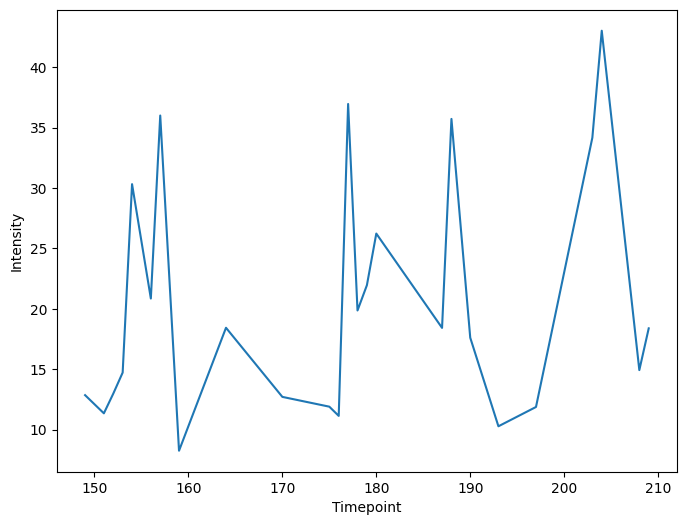

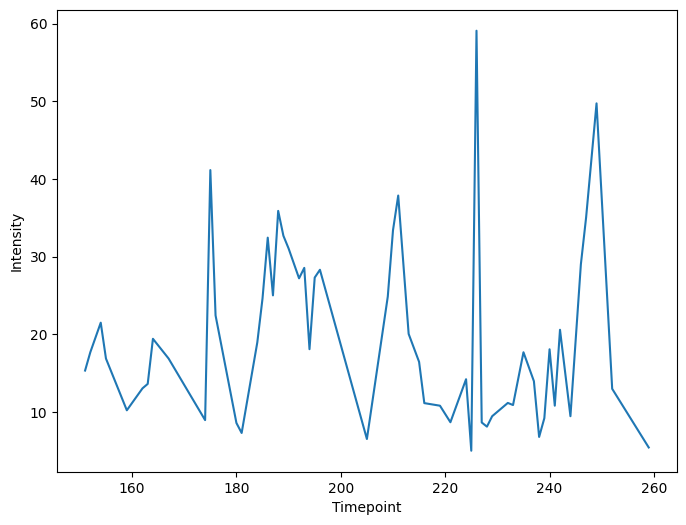

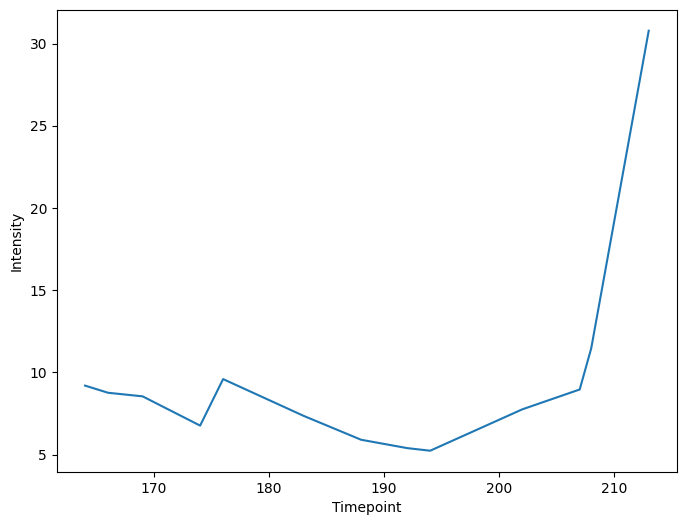

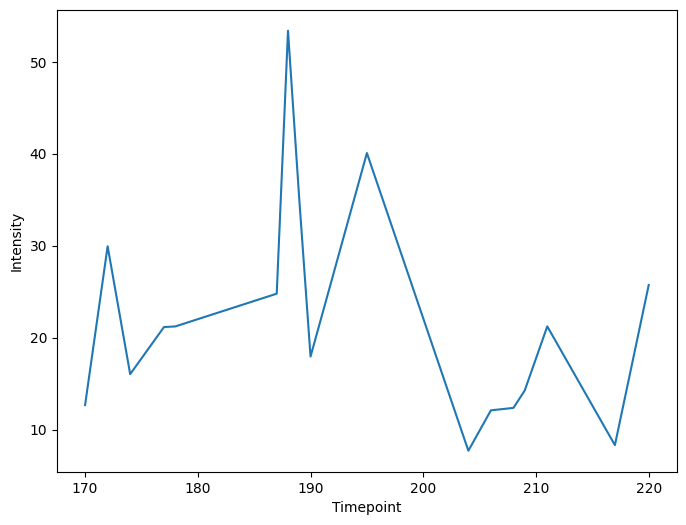

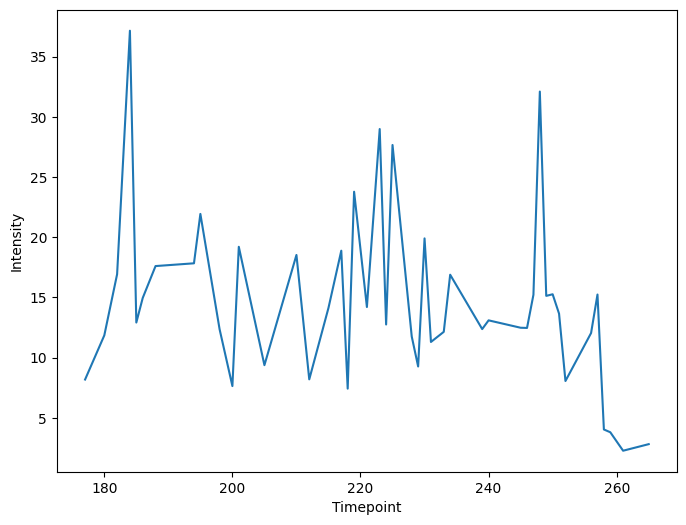

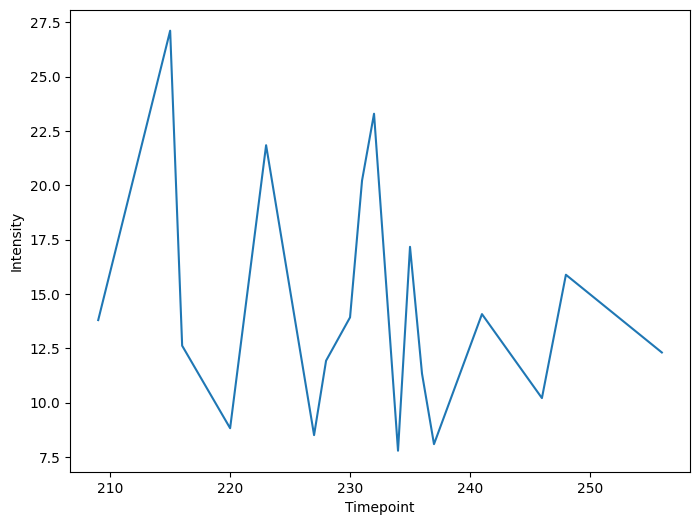

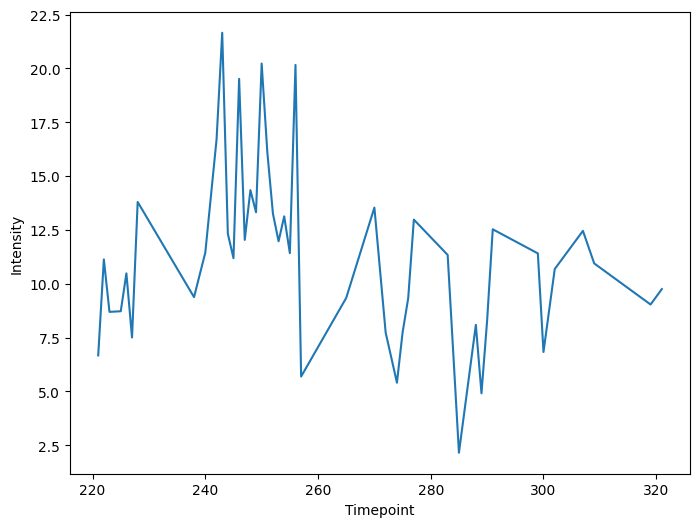

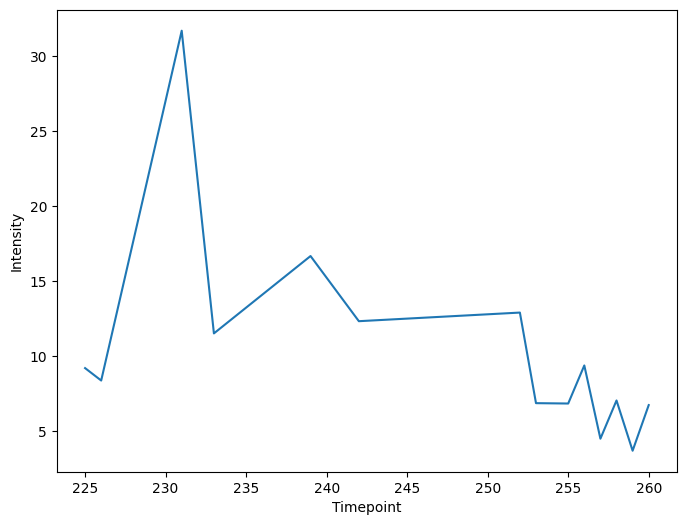

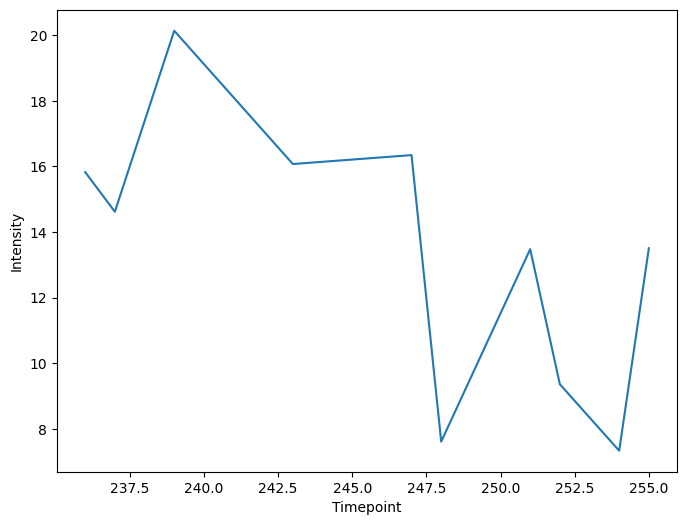

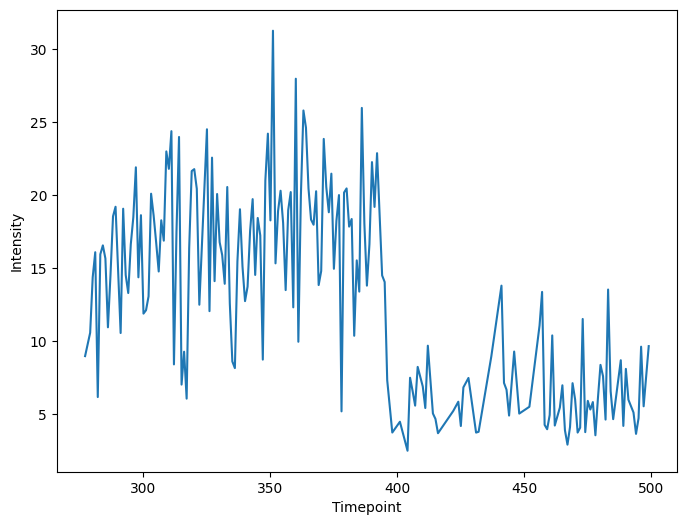

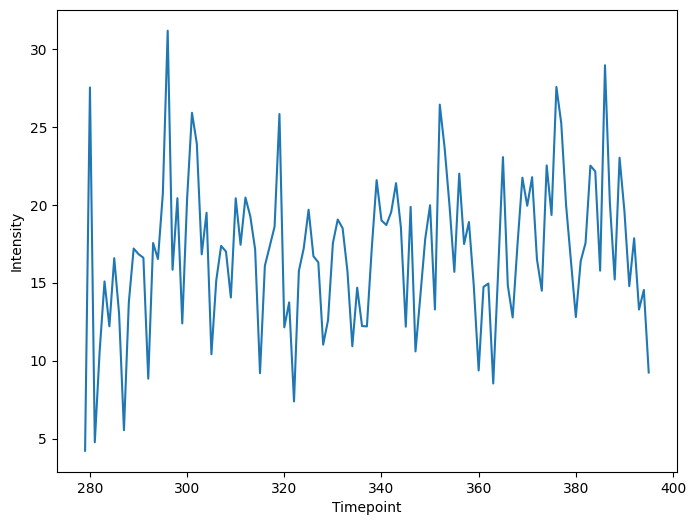

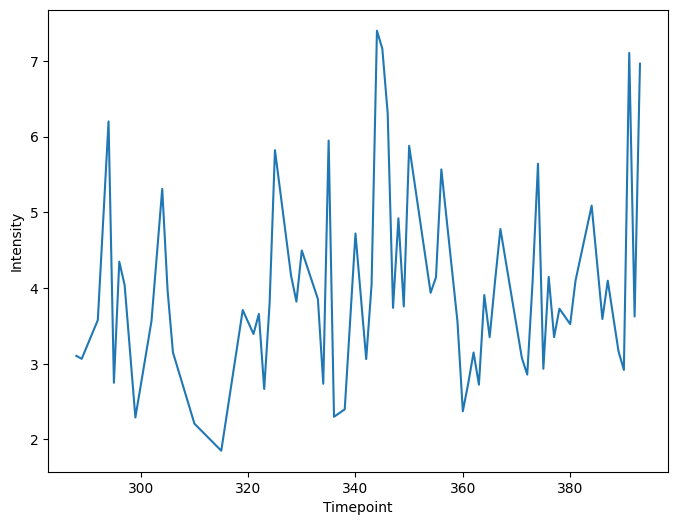

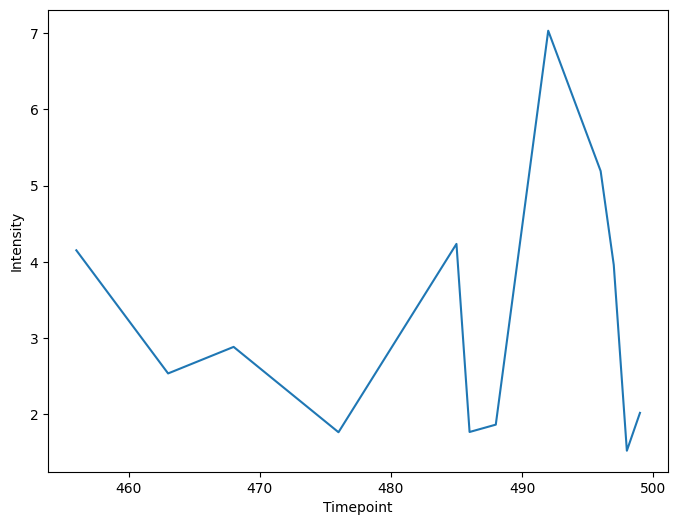

In [9]:
# Measuring intensity
for track in tracks.values():
    track.measure_intensity(image)

# Step fitting (to be added later)
# ksf.fit_steps(tracks,image)

# Saving files
kio.save_overlay(tracks,image,rootpath+rootname+'_C'+str(channel)+"_overlay")
kio.write_peak_traces(tracks,rootpath+rootname+'_C'+str(channel)+"_traces")
kio.save_plots(tracks,rootpath+rootname+'_C'+str(channel)+"_traces")
# kio.write_change_points(tracks,rootpath+rootname+'_C'+str(channel)+'_steps')